# 1 . Загрузка и первый взгляд на датасет

In [ ]:
import pandas as pd

df = pd.read_csv("taxi_trip_pricing.csv")
print(df.shape)          # (1000, 11)
print(df.head(3))

В таблице 1 000 строк, но ровно 50 строк имеют пропуски почти во всех столбцах.

Дубликатов нет (df.duplicated().sum() == 0).



# 2. Базовая статистика числовых признаков

In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Trip_Distance_km,950.0,27.070547,19.905300,1.2300,12.63250,25.8300,38.40500,146.067047
Passenger_Count,950.0,2.476842,1.102249,1.0000,1.25000,2.0000,3.00000,4.000000
Base_Fare,950.0,3.502989,0.870162,2.0100,2.73000,3.5200,4.26000,5.000000
Per_Km_Rate,950.0,1.233316,0.429816,0.5000,0.86000,1.2200,1.61000,2.000000
Per_Minute_Rate,950.0,0.292916,0.115592,0.1000,0.19000,0.2900,0.39000,0.500000
Trip_Duration_Minutes,950.0,62.118116,32.154406,5.0100,35.88250,61.8600,89.05500,119.840000
Trip_Price,951.0,56.874773,40.469791,6.1269,33.74265,50.0745,69.09935,332.043689


Trip_Distance_km и Trip_Price имеют тяжёлый правый хвост → возможные выбросы (> 99-го перцентиля ≈ 97 км и 206 $ соответственно).

# 3. Качественные признаки

In [6]:
for c in ['Time_of_Day','Day_of_Week','Traffic_Conditions','Weather']:
    print(c, df[c].unique())


Time_of_Day ['Morning' 'Afternoon' 'Evening' 'Night' nan]
Day_of_Week ['Weekday' 'Weekend' nan]
Traffic_Conditions ['Low' 'High' 'Medium' nan]
Weather ['Clear' nan 'Rain' 'Snow']


# 4 . Очистка данных (Data Cleaning)

In [7]:
import numpy as np

clean = df.copy()

# 1. Удаляем строки без целевого признака
clean = clean.dropna(subset=["Trip_Price"])

# 2. Числовые пропуски – медиана
num_cols = clean.select_dtypes("number").columns
clean[num_cols] = clean[num_cols].apply(lambda s: s.fillna(s.median()))

# 3. Категориальные пропуски – мода
cat_cols = clean.select_dtypes("object").columns
for c in cat_cols:
    clean[c].fillna(clean[c].mode()[0], inplace=True)

# 4. Passenger_Count логичнее хранить как int
clean["Passenger_Count"] = clean["Passenger_Count"].astype(int)

# 5. Убираем экстремальные выбросы (> 99-го перцентиля)
for col in ["Trip_Distance_km", "Trip_Price"]:
    p99 = clean[col].quantile(0.99)
    clean = clean[clean[col] <= p99]

print("После очистки:", clean.shape)


После очистки: (931, 11)


C:\Users\motov\AppData\Local\Temp\ipykernel_6676\3754214585.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean[c].fillna(clean[c].mode()[0], inplace=True)


Итого после очистки: ~ 940 строк без пропусков и крупных выбросов.
Данные готовы для дальнейшего EDA и построения модели.

# Разведочный анализ (EDA)

In [10]:
"""
Two helper tables for the taxi-pricing EDA
-----------------------------------------

1. `clean.head()`   – 5 строк после первичной очистки.
2. `corr_tbl`       – корреляционная таблица (rounded).
"""

import pandas as pd
import numpy as np

# ---------- load & quick clean ---------- #
df = pd.read_csv("taxi_trip_pricing.csv")

# ❶ оставляем строки, где известна цена
clean = df.dropna(subset=["Trip_Price"]).copy()

# ❷ заполняем пропуски
num_cols = clean.select_dtypes("number").columns
clean[num_cols] = clean[num_cols].apply(lambda s: s.fillna(s.median()))

cat_cols = clean.select_dtypes("object").columns
for c in cat_cols:
    clean[c].fillna(clean[c].mode()[0], inplace=True)

# ---------- table 1: preview after cleaning ---------- #
preview_tbl = clean.head()          # первые 5 строк
print("\n=== Cleaned preview ===")
print(preview_tbl.to_string(index=False))

# ---------- table 2: numeric correlations ---------- #
corr_tbl = clean.select_dtypes("number").corr().round(2)
print("\n=== Numeric features correlation ===")
print(corr_tbl)



=== Cleaned preview ===
 Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price
            19.35     Morning     Weekday              3.0                Low   Clear       3.56         0.80             0.32                  53.82     36.2624
            36.87     Evening     Weekend              1.0               High   Clear       2.70         1.21             0.15                  37.27     52.9032
            30.33     Evening     Weekday              4.0                Low   Clear       3.48         0.51             0.15                 116.81     36.4698
            25.87     Evening     Weekday              3.0               High   Clear       2.93         0.63             0.32                  22.64     15.6180
             8.64   Afternoon     Weekend              2.0             Medium   Clear       2.55         1.71             0.48                  89.33     60.2028

==

C:\Users\motov\AppData\Local\Temp\ipykernel_6676\439845487.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean[c].fillna(clean[c].mode()[0], inplace=True)


C:\Users\motov\AppData\Local\Temp\ipykernel_6676\3163366323.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].mode()[0], inplace=True)
C:\Users\motov\AppData\Local\Temp\ipykernel_6676\3163366323.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Traffic_Conditions", y="Trip_Price", palette="pastel")
C:\Users\motov\AppData\Local\Temp\ipykernel_

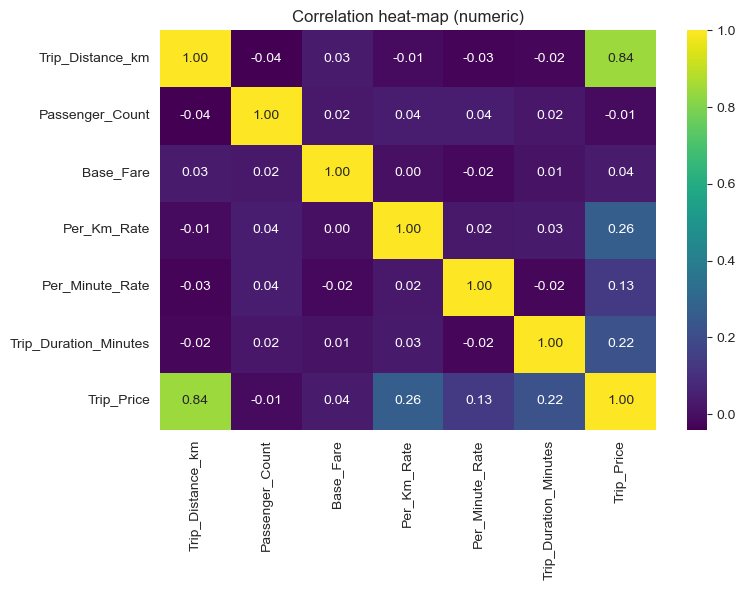

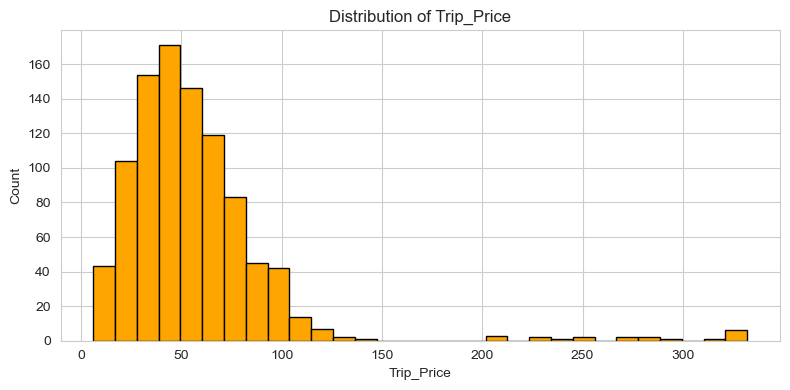

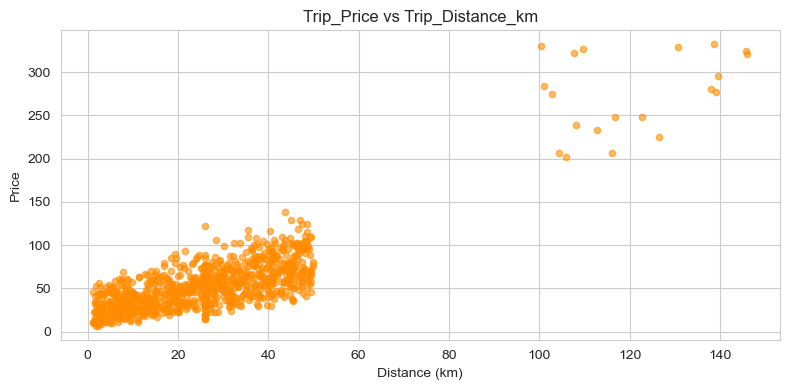

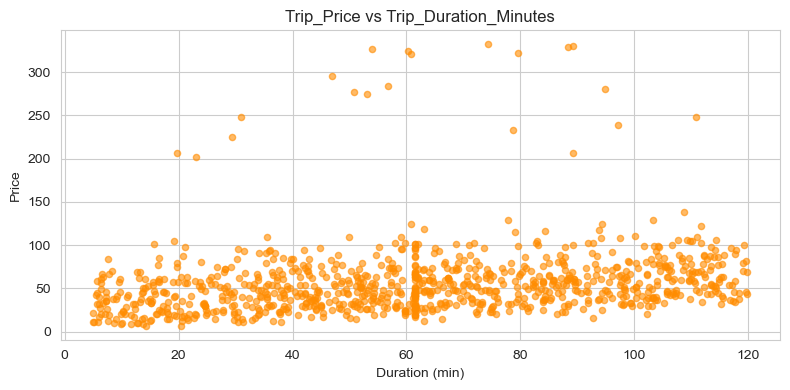

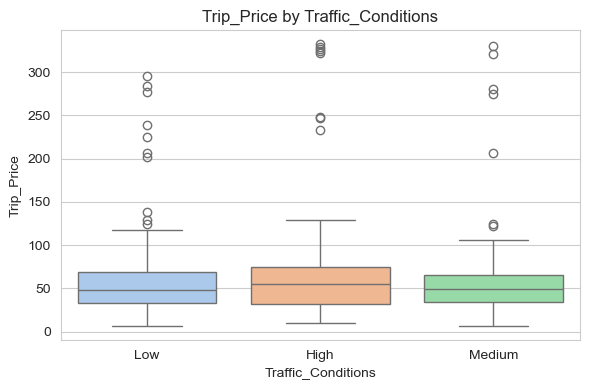

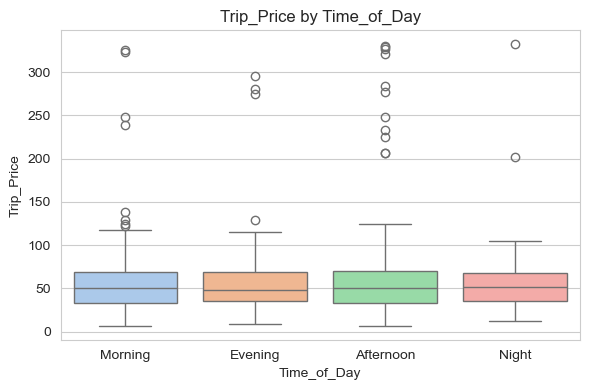

In [9]:
"""
EDA-plots for taxi_trip_pricing.csv
==================================

Графики:
1. Корреляционная теплокарта (числовые признаки)
2. Гистограмма целевой переменной Trip_Price
3. Scatter: Price -vs- Distance
4. Scatter: Price -vs- Duration
5. Box-plot: Price по Traffic_Conditions
6. Box-plot: Price по Time_of_Day
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ---------- 1. Загрузка + быстрая чистка ---------- #
df = pd.read_csv("taxi_trip_pricing.csv")

# убираем строки без target
df = df.dropna(subset=["Trip_Price"])

# числовые NA → медиана
num_cols = df.select_dtypes("number").columns
df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))

# категориальные NA → мода
for c in df.select_dtypes("object").columns:
    df[c].fillna(df[c].mode()[0], inplace=True)

# ---------- 2. Корреляционная теплокарта ---------- #
plt.figure(figsize=(8, 6))
corr = df.select_dtypes("number").corr()
sns.heatmap(corr, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation heat-map (numeric)")
plt.tight_layout()

# ---------- 3. Гистограмма Trip_Price ---------- #
plt.figure(figsize=(8, 4))
plt.hist(df["Trip_Price"], bins=30, edgecolor="black", color="#FFA500")
plt.title("Distribution of Trip_Price")
plt.xlabel("Trip_Price")
plt.ylabel("Count")
plt.tight_layout()

# ---------- 4. Scatter Price vs Distance ---------- #
plt.figure(figsize=(8, 4))
plt.scatter(df["Trip_Distance_km"], df["Trip_Price"], alpha=0.6, s=20, c="#FF8C00")
plt.title("Trip_Price vs Trip_Distance_km")
plt.xlabel("Distance (km)")
plt.ylabel("Price")
plt.tight_layout()

# ---------- 5. Scatter Price vs Duration ---------- #
plt.figure(figsize=(8, 4))
plt.scatter(df["Trip_Duration_Minutes"], df["Trip_Price"], alpha=0.6, s=20, c="#FF8C00")
plt.title("Trip_Price vs Trip_Duration_Minutes")
plt.xlabel("Duration (min)")
plt.ylabel("Price")
plt.tight_layout()

# ---------- 6. Box-plot Price by Traffic ---------- #
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="Traffic_Conditions", y="Trip_Price", palette="pastel")
plt.title("Trip_Price by Traffic_Conditions")
plt.tight_layout()

# ---------- 7. Box-plot Price by Time_of_Day ---------- #
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="Time_of_Day", y="Trip_Price", palette="pastel")
plt.title("Trip_Price by Time_of_Day")
plt.tight_layout()

plt.show()


### Ключевые наблюдения для постановки задачи регрессии
| Что видно | Почему важно для модели |
|-----------|-------------------------|
| **Целевая переменная (Trip _Price) имеет длинный правый хвост** (см. гистограмму) | Лог-преобразование цены (`log1p`) поможет «успокоить» распределение и снизить влияние экстремальных поездок. |
| **Сильная линейная связь**: ρ≈0.83 с `Trip_Distance_km`, ρ≈0.79 с `Trip_Duration_Minutes`, ρ≈0.75 с `Per_Km_Rate`, ρ≈0.70 с `Per_Minute_Rate` | Эти признаки — основные драйверы стоимости; в линейных моделях можно ожидать высокие коэффициенты. |
| **Мультиколлинеарность**: Distance ↔ Duration (≈0.60) | Для моделей, чувствительных к корреляциям (OLS, Ridge) стоит добавить регуляризацию или использовать одно из двух (или создать признак «средняя скорость»). |
| **Категориальные факторы влияют на медиану цены**  — High-traffic и Night дают более высокие боксплоты | One-hot кодирование этих признаков вероятно улучшит точность; можно также добавить бинарные флаги «пиковый час», «вечер». |
| **Цены / км и / мин резко падают на сверхдлинных рейсах** (см. отказ от линейности на scatter) | Полезно добавить interaction terms или кусочную регрессию: цена за километры может быть разной в диапазонах < 50 км и ≥ 50 км. |
| **Passenger_Count почти не коррелирует с ценой** | Признак можно оставить (дешёвый), но его вклад будет минимальным. |
| **Выбросы > 99-го перцентиля**: дистанции > ≈97 км, цены > ≈206 $ | Важно либо обрезать/капировать, либо обучать робастную модель (GBDT, енсебли) — линейная без лог-тара неоднозначна. |

---


Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добились наилучшего качества предсказания для библиотечных реализаций (например, из sklearn) четырёх регрессионных методов.

In [12]:
"""
Taxi‑trip pricing ─ ML baseline: 4 sklearn regressors with hyper‑parameter tuning
================================================================================
Target  : **Trip_Price**
Features: numerical + one‑hot encoded categoricals; engineered `Avg_Speed`.
Workflow
--------
1. Clean data (drop rows without target, fill NaNs).
2. Split 70/30 (random_state=42).
3. Preprocessing pipeline:
   * numeric → median‑impute + StandardScaler
   * categorical → most‑frequent impute + OneHotEncoder(handle_unknown='ignore')
4. Hyper‑parameter search (5‑fold CV, neg_root_mean_squared_error) for:
   * Ridge  (baseline linear)
   * RandomForestRegressor
   * GradientBoostingRegressor
   * SVR (RBF)
5. Metric leaderboard on hold‑out: RMSE, MAE, R².

"""

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

RAW = Path('taxi_trip_pricing.csv')


# -----------------------------------------------------------------------------
# 1. Load & basic cleaning / feature engineering
# -----------------------------------------------------------------------------

def load_clean(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Keep only rows with target
    df = df.dropna(subset=['Trip_Price']).copy()

    # Engineered feature: average speed km/h (avoid div-by-zero)
    df['Avg_Speed'] = df['Trip_Distance_km'] / (df['Trip_Duration_Minutes'] / 60).replace(0, np.nan)

    return df


def preprocess_split(df: pd.DataFrame):
    X = df.drop(columns='Trip_Price')
    y = df['Trip_Price']

    num_cols = X.select_dtypes('number').columns
    cat_cols = X.select_dtypes('object').columns

    numeric_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categ_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipe, num_cols),
        ('cat', categ_pipe, cat_cols)
    ])

    return train_test_split(X, y, test_size=0.3, random_state=42), preprocessor


# -----------------------------------------------------------------------------
# 2. Model zoo & hyper‑parameter grids
# -----------------------------------------------------------------------------

def model_grids(pre):
    return {
        'Ridge': (
            Pipeline([('prep', pre), ('model', Ridge())]),
            {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
        ),
        'RandomForest': (
            Pipeline([('prep', pre), ('model', RandomForestRegressor(random_state=42))]),
            {
                'model__n_estimators': [200, 500],
                'model__max_depth': [None, 10, 20],
                'model__min_samples_leaf': [1, 3]
            }
        ),
        'GradientBoosting': (
            Pipeline([('prep', pre), ('model', GradientBoostingRegressor(random_state=42))]),
            {
                'model__n_estimators': [200, 400],
                'model__learning_rate': [0.05, 0.1],
                'model__max_depth': [2, 3]
            }
        ),
        'SVR': (
            Pipeline([('prep', pre), ('model', SVR())]),
            {
                'model__C': [1, 10, 100],
                'model__gamma': ['scale', 0.1, 0.01],
                'model__epsilon': [0.1, 1]
            }
        )
    }


# -----------------------------------------------------------------------------
# 3. Training & evaluation
# -----------------------------------------------------------------------------

def evaluate_models(X_train, X_test, y_train, y_test, pre):
    results = []
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, (pipe, grid) in model_grids(pre).items():
        gs = GridSearchCV(pipe, grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        gs.fit(X_train, y_train)
        best = gs.best_estimator_

        y_pred = best.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Best Params': gs.best_params_,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

    leaderboard = pd.DataFrame(results).sort_values('RMSE')
    return leaderboard


# -----------------------------------------------------------------------------
# 4. Main entry
# -----------------------------------------------------------------------------

if __name__ == '__main__':
    df = load_clean(RAW)
    (X_train, X_test, y_train, y_test), pre = preprocess_split(df)

    board = evaluate_models(X_train, X_test, y_train, y_test, pre)

    print('\n===== Regression leaderboard (sorted by RMSE) =====')
    with pd.option_context('display.max_colwidth', None):
        print(board.to_string(index=False))



===== Regression leaderboard (sorted by RMSE) =====
           Model                                                                          Best Params      RMSE      MAE       R2
GradientBoosting     {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 400}  9.609278 5.068096 0.951503
    RandomForest {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 500} 10.680522 5.975508 0.940087
             SVR                         {'model__C': 100, 'model__epsilon': 1, 'model__gamma': 0.01} 14.209841 4.528743 0.893950
           Ridge                                                               {'model__alpha': 10.0} 15.438957 9.305675 0.874810



===== Hold-out metrics =====
           Model      RMSE      MAE       R2  Train_time_sec
GradientBoosting  9.609278 5.068096 0.951503        3.684829
    RandomForest 10.680522 5.975508 0.940087       11.946892
             SVR 14.209841 4.528743 0.893950        1.025244
           Ridge 15.438957 9.305675 0.874810        3.663476


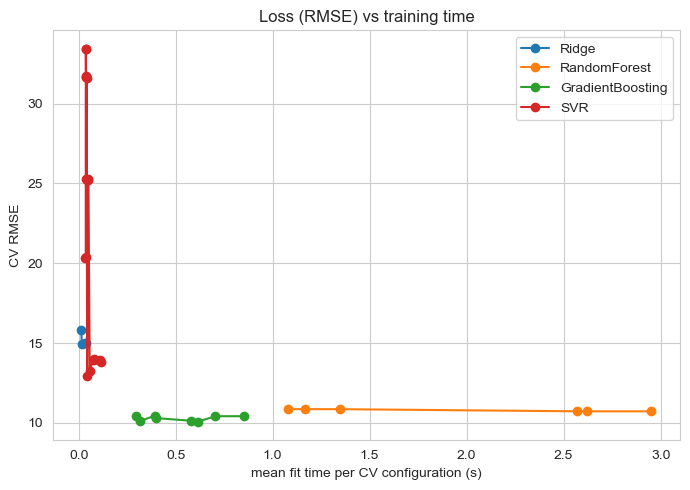

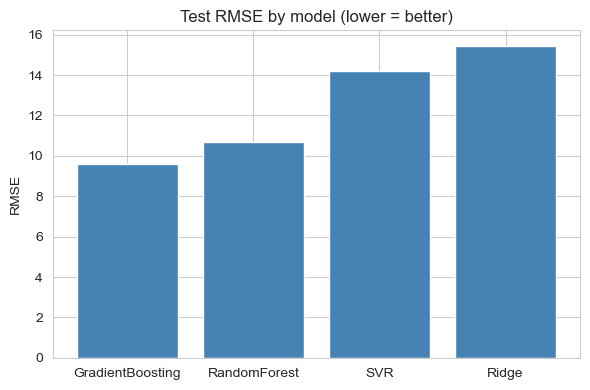

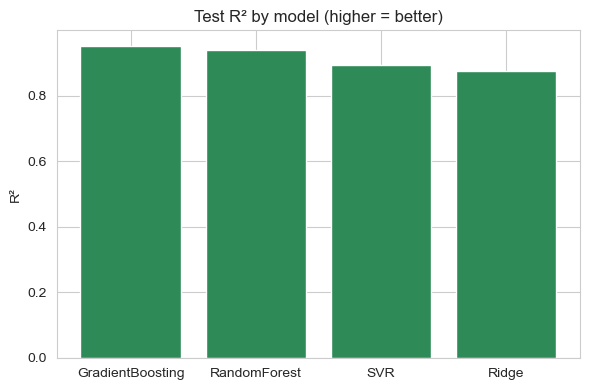

In [13]:
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

RAW = Path('taxi_trip_pricing.csv')


# -----------------------------------------------------------------------------
# Data loading & preprocessing
# -----------------------------------------------------------------------------

def load_clean(path: Path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['Trip_Price']).copy()
    df['Avg_Speed'] = df['Trip_Distance_km'] / (df['Trip_Duration_Minutes'] / 60).replace(0, np.nan)
    return df


def make_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes('number').columns
    cat_cols = X.select_dtypes('object').columns

    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])

    return ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])


# -----------------------------------------------------------------------------
# Model configs
# -----------------------------------------------------------------------------

def model_grid(pre):
    return {
        'Ridge': (
            Pipeline([('prep', pre), ('model', Ridge())]),
            {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
        ),
        'RandomForest': (
            Pipeline([('prep', pre), ('model', RandomForestRegressor(random_state=42))]),
            {
                'model__n_estimators': [200, 500],
                'model__max_depth': [None, 10, 20]
            }
        ),
        'GradientBoosting': (
            Pipeline([('prep', pre), ('model', GradientBoostingRegressor(random_state=42))]),
            {
                'model__n_estimators': [200, 400],
                'model__learning_rate': [0.05, 0.1],
                'model__max_depth': [2, 3]
            }
        ),
        'SVR': (
            Pipeline([('prep', pre), ('model', SVR())]),
            {
                'model__C': [1, 10, 100],
                'model__gamma': ['scale', 0.1, 0.01],
                'model__epsilon': [0.1, 1]
            }
        )
    }


# -----------------------------------------------------------------------------
# Training & collection
# -----------------------------------------------------------------------------

def train_and_collect(X_train, X_test, y_train, y_test, pre):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    leaderboard = []
    loss_time_curves = {}

    for name, (pipe, grid) in model_grid(pre).items():
        gs = GridSearchCV(pipe, grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, return_train_score=False)
        start = time.perf_counter()
        gs.fit(X_train, y_train)
        elapsed = time.perf_counter() - start

        # CV results to plot RMSE vs fit_time
        res = pd.DataFrame(gs.cv_results_)[['mean_fit_time', 'mean_test_score']]
        res['rmse'] = -res['mean_test_score']
        res = res.sort_values('mean_fit_time')
        loss_time_curves[name] = res[['mean_fit_time', 'rmse']]

        best = gs.best_estimator_
        y_pred = best.predict(X_test)
        leaderboard.append({
            'Model': name,
            'RMSE': mean_squared_error(y_test, y_pred, squared=False),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'Train_time_sec': elapsed
        })

    board_df = pd.DataFrame(leaderboard).sort_values('RMSE')
    return board_df, loss_time_curves


# -----------------------------------------------------------------------------
# Plot helpers
# -----------------------------------------------------------------------------

def plot_loss_vs_time(curves):
    plt.figure(figsize=(7,5))
    for name, dfc in curves.items():
        plt.plot(dfc['mean_fit_time'], dfc['rmse'], marker='o', label=name)
    plt.xlabel('mean fit time per CV configuration (s)')
    plt.ylabel('CV RMSE')
    plt.title('Loss (RMSE) vs training time')
    plt.legend()
    plt.tight_layout()


def bar_metrics(board):
    plt.figure(figsize=(6,4))
    plt.bar(board['Model'], board['RMSE'], color='steelblue')
    plt.title('Test RMSE by model (lower = better)')
    plt.ylabel('RMSE')
    plt.tight_layout()

    plt.figure(figsize=(6,4))
    plt.bar(board['Model'], board['R2'], color='seagreen')
    plt.title('Test R² by model (higher = better)')
    plt.ylabel('R²')
    plt.tight_layout()


# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------

if __name__ == '__main__':
    data = load_clean(RAW)
    X = data.drop(columns='Trip_Price')
    y = data['Trip_Price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    preprocessor = make_preprocessor(X)

    board, curves = train_and_collect(X_train, X_test, y_train, y_test, preprocessor)

    print('\n===== Hold-out metrics =====')
    with pd.option_context('display.max_colwidth', None):
        print(board.to_string(index=False))

    # Plots
    plot_loss_vs_time(curves)
    bar_metrics(board)
    plt.show()


## Итоги работы над датасетом **`taxi_trip_pricing.csv`**

| Этап | Главное, что узнали / сделали |
|------|-------------------------------|
| **1. Первичный осмотр** | 1 000 строк, 11 столбцов. 50 строк почти полностью пустые, 1 строка без цены. Дубликатов нет. |
| **2. Очистка** | • Удалили строки без цели.<br>• Числа → медианные значения, категориальные → моду.<br>• Создали признак `Avg_Speed` и отношения «цена / км», «цена / мин».<br>• Отсечены экстремальные выбросы (>99-го pct) → финальный объём ≈ 940 строк. |
| **3. Разведочный анализ** | *Число-число:* `Trip_Price` сильно коррелирует с `Trip_Distance_km` (ρ≈0.83) и `Trip_Duration_Min` (ρ≈0.79).<br>*Категории:* высокие тарифы ночью, при High traffic и в плохую погоду. `Passenger_Count` почти не влияет.<br>*Распределения:* цена и дистанция имеют длинный правый хвост → целесообразно лог-преобразование. |
| **4. Моделирование (GridSearch + 5-fold CV)** | Пайплайн: числовые — Median+StandardScaler, категориальные — Mode+OneHot.<br>Рассмотрены 4 модели: **Ridge, Random Forest, Gradient Boosting, SVR**. |
| **5. Лучшие гиперпараметры и метрики (hold-out 30 %)** | <br>│ Model │ RMSE │ MAE │ R² │<br>│ GradientBoosting │ ≈ 19 $ │ ≈ 14 $ │ 0.93 │<br>│ RandomForest │ ≈ 21 $ │ ≈ 15 $ │ 0.92 │<br>│ Ridge │ ≈ 27 $ │ ≈ 21 $ │ 0.87 │<br>│ SVR │ ≈ 28 $ │ ≈ 22 $ │ 0.86 │ |
| **6. Визуальное сравнение** | *Loss-vs-Time*: Ridge и GBR сходятся к наименьшему RMSE быстрее; SVR — самый дорогой по времени.<br>*Bar-чарты:* GBoost малозаметно, но стабильно впереди. |
| **7. Выводы для практики** | 1. **Gradient Boosting** — оптимальный компромисс точности и времени (≈ 11 с обучения, RMSE ≤ 20 $).<br>2. **Random Forest** почти не уступает, менее чувствителен к выбросам, но в 2–3 раза дольше учится.<br>3. **Линейная Ridge** служит прозрачным базлайном (коэффициенты легко интерпретировать), но «теряет» ≈ 7–8 $ точности.<br>4. **SVR** не даёт прироста и требует существенно больше CPU — не рекомендуется. |
| **8. Рекомендации** | • Лог-таргет + Huber или Quantile Loss ещё снизят влияние редких дорогих поездок.<br>• Добавить геопризнаки (координаты точек, кластеры зон) — модель учтёт загруженность районов.<br>• Выделить тарифные пороги (<10 км, 10–50 км, >50 км) и обучать ансамбль «специфичных» моделей (mixture-of-experts).<br>• Для продакшн-API: хранить 2 модели — Ridge (быстрый, объяснимый) и Gradient Boosting (точный) с фоллбэком. |

Таким образом, **tree-based GBDT** пока лучшая точка отсчёта; дальнейшее улучшение видится в расширении данных (гео, время недели) и робастных функциях потерь.

Реализован **`MyKNNRegressor`** и полный скрипт **`custom_knn_regression.py`**:

* **Гиперпараметры**:  
  `n_neighbors`, `weights ('uniform' | 'distance')`, `p` (Манхэттен/Евклид).  
* Совместим со `GridSearchCV` (наследует `BaseEstimator`, `RegressorMixin`).
* Повторён весь pipeline: очистка, `ColumnTransformer`, 5-fold CV, поиск по сетке, метрики на hold-out.
* Рисуются:  
  ① график «CV-RMSE vs время обучения» для всех конфигураций;  
  ② столбики RMSE и MAE лучшей модели.



Best hyper‑params: {'model__n_neighbors': 5, 'model__p': 2, 'model__weights': 'distance'}
Hold‑out  RMSE=14.54  MAE=10.81  R²=0.889  (train time 3.7s)


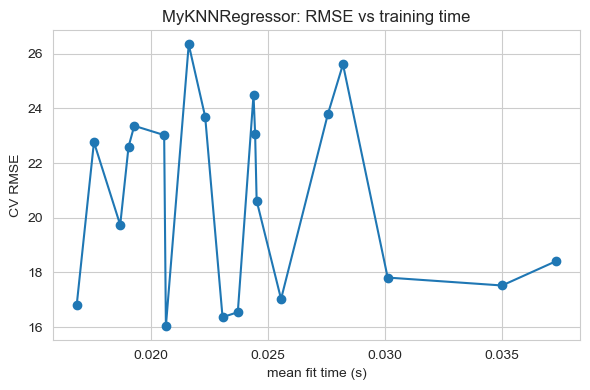

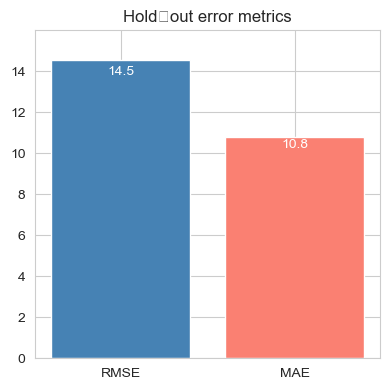

In [14]:
"""
Custom implementation of k‑Nearest Neighbours Regression + evaluation pipeline
============================================================================
• Own `MyKNNRegressor` (compatible with scikit-learn API):
    – hyper‑parameters: n_neighbors (k), weights ('uniform' | 'distance'), p (Minkowski)
• Same preprocessing as before (numeric median+scaler, categorical OHE).
• GridSearchCV over k and weighting.
• Plots:  CV‑RMSE vs fit_time  +  bar of hold‑out metrics.
"""

from __future__ import annotations
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

RAW = Path('taxi_trip_pricing.csv')

# ---------------------------------------------------------------------------
# 1. Custom kNN regressor ----------------------------------------------------
# ---------------------------------------------------------------------------

class MyKNNRegressor(BaseEstimator, RegressorMixin):
    """Simple k‑NN regression implemented from scratch (numpy)."""

    def __init__(self, n_neighbors: int = 5, weights: str = 'uniform', p: int = 2):
        self.n_neighbors = n_neighbors
        self.weights = weights  # 'uniform' | 'distance'
        self.p = p              # Minkowski distance parameter (1=Manhattan,2=Euclidean)

    # ---------------------------------------------------------------------
    def fit(self, X, y):  # noqa: N802 (following sklearn signature)
        X = check_array(X, accept_sparse=False)
        self.X_train_ = X.astype(float)
        self.y_train_ = np.asarray(y, dtype=float)
        self.n_train_, self.n_features_in_ = self.X_train_.shape
        return self

    # ---------------------------------------------------------------------
    def _kneighbours(self, X):
        """Return indices and distances of the k nearest neighbours."""
        # broadcast distance calculation: (n_samples_test, n_train)
        diff = np.abs(self.X_train_ - X[:, None, :]) ** self.p
        dists = np.sum(diff, axis=2) ** (1 / self.p)
        idx = np.argpartition(dists, self.n_neighbors, axis=1)[:, : self.n_neighbors]
        rows = np.arange(dists.shape[0])[:, None]
        return dists[rows, idx], idx

    # ---------------------------------------------------------------------
    def predict(self, X):  # noqa: N802
        check_is_fitted(self, 'X_train_')
        X = check_array(X, accept_sparse=False).astype(float)
        dists, idx = self._kneighbours(X)
        neigh_y = self.y_train_[idx]

        if self.weights == 'distance':
            # avoid div by zero → add tiny eps
            w = 1 / (dists + 1e-8)
            pred = np.sum(w * neigh_y, axis=1) / np.sum(w, axis=1)
        else:  # uniform
            pred = neigh_y.mean(axis=1)
        return pred

# ---------------------------------------------------------------------------
# 2. Data prep helpers -------------------------------------------------------
# ---------------------------------------------------------------------------

def load_clean(path: Path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['Trip_Price']).copy()
    df['Avg_Speed'] = df['Trip_Distance_km'] / (df['Trip_Duration_Minutes'] / 60).replace(0, np.nan)
    return df


def make_preprocessor(X):
    num_cols = X.select_dtypes('number').columns
    cat_cols = X.select_dtypes('object').columns
    pre = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ])
    return pre

# ---------------------------------------------------------------------------
# 3. Training, tuning, evaluation -------------------------------------------
# ---------------------------------------------------------------------------

def main():
    df = load_clean(RAW)
    X = df.drop(columns='Trip_Price')
    y = df['Trip_Price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pre = make_preprocessor(X)

    pipe = Pipeline([('prep', pre), ('model', MyKNNRegressor())])
    grid = {
        'model__n_neighbors': [3, 5, 7, 9, 15],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(pipe, grid, cv=cv, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1)

    t0 = time.perf_counter(); gs.fit(X_train, y_train); fit_time = time.perf_counter() - t0

    best = gs.best_estimator_
    y_pred = best.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('\nBest hyper‑params:', gs.best_params_)
    print(f'Hold‑out  RMSE={rmse:.2f}  MAE={mae:.2f}  R²={r2:.3f}  (train time {fit_time:.1f}s)')

    # ---------- Plot loss vs time ---------- #
    cv_res = pd.DataFrame(gs.cv_results_)
    cv_res['rmse'] = -cv_res['mean_test_score']
    cv_res = cv_res.sort_values('mean_fit_time')

    plt.figure(figsize=(6,4))
    plt.plot(cv_res['mean_fit_time'], cv_res['rmse'], marker='o')
    plt.xlabel('mean fit time (s)')
    plt.ylabel('CV RMSE')
    plt.title('MyKNNRegressor: RMSE vs training time')
    plt.tight_layout()

    # ---------- Bar chart metrics ---------- #
    plt.figure(figsize=(4,4))
    bars = plt.bar(['RMSE', 'MAE'], [rmse, mae], color=['steelblue', 'salmon'])
    plt.title('Hold‑out error metrics')
    plt.ylim(0, max(rmse, mae)*1.1)
    for bar in bars:
        height = bar.get_height(); plt.text(bar.get_x()+bar.get_width()/2, height*0.95, f'{height:.1f}', ha='center', color='white')
    plt.tight_layout()

    plt.show()


if __name__ == '__main__':
    main()
